In [ ]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

Lambda: 0, Epoch: 10/50| Avg loss: 0.13661
Lambda: 0, Epoch: 20/50| Avg loss: 0.13112
Lambda: 0, Epoch: 30/50| Avg loss: 0.13104
Lambda: 0, Epoch: 40/50| Avg loss: 0.13104
Lambda: 0, Epoch: 50/50| Avg loss: 0.13104
Lambda: 0.001, Epoch: 10/50| Avg loss: 0.13365
Lambda: 0.001, Epoch: 20/50| Avg loss: 0.13160
Lambda: 0.001, Epoch: 30/50| Avg loss: 0.13155
Lambda: 0.001, Epoch: 40/50| Avg loss: 0.13155
Lambda: 0.001, Epoch: 50/50| Avg loss: 0.13155
Lambda: 0.01, Epoch: 10/50| Avg loss: 0.13797
Lambda: 0.01, Epoch: 20/50| Avg loss: 0.13608
Lambda: 0.01, Epoch: 30/50| Avg loss: 0.13604
Lambda: 0.01, Epoch: 40/50| Avg loss: 0.13604
Lambda: 0.01, Epoch: 50/50| Avg loss: 0.13604
Lambda: 0.1, Epoch: 10/50| Avg loss: 0.17560
Lambda: 0.1, Epoch: 20/50| Avg loss: 0.17473
Lambda: 0.1, Epoch: 30/50| Avg loss: 0.17473
Lambda: 0.1, Epoch: 40/50| Avg loss: 0.17473
Lambda: 0.1, Epoch: 50/50| Avg loss: 0.17473
Lambda: 1, Epoch: 10/50| Avg loss: 0.33420
Lambda: 1, Epoch: 20/50| Avg loss: 0.33420
Lambda: 1

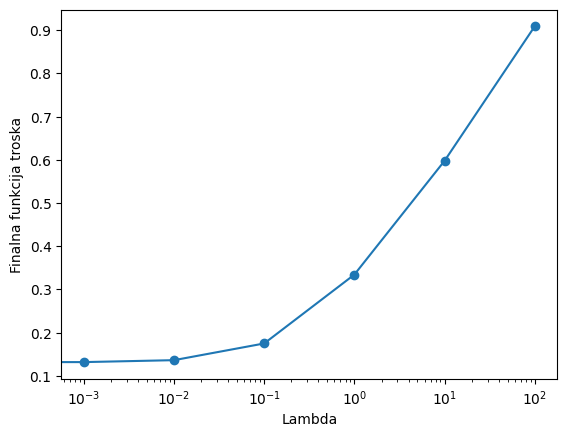

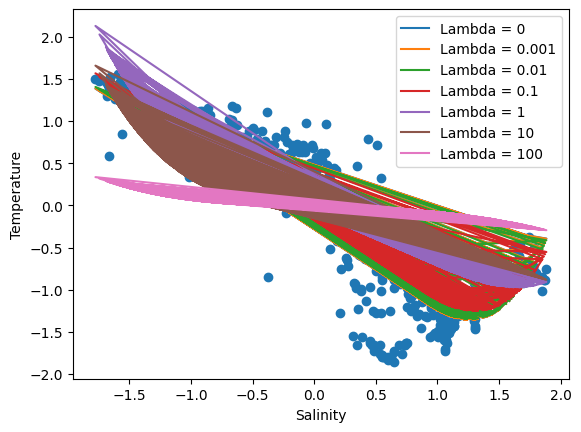

In [ ]:
# Pomocna funkcija koja od niza trening primera pravi feature matricu (m X n).
def create_feature_matrix(x, nb_features):
    tmp_features = []
    for deg in range(1, nb_features + 1):
        tmp_features.append(np.power(x, deg))
    return np.column_stack(tmp_features)

filename = 'bottle.csv'
all_data = np.genfromtxt(filename, delimiter=',', skip_header=1, usecols=(5, 6), max_rows=700, missing_values='', filling_values=np.nan)

# Redovi u kojima je bilo prazno polje su isključeni iz obrade podataka.
all_data = all_data[~np.isnan(all_data).any(axis=1)]
data = dict()
data['x'] = all_data[:, 0].astype(np.float32)
data['y'] = all_data[:, 1].astype(np.float32)

# Normalizacija (obratiti pažnju na axis=0).
data['x'] = (data['x'] - np.mean(data['x'], axis=0)) / np.std(data['x'], axis=0)
data['y'] = (data['y'] - np.mean(data['y'])) / np.std(data['y'])

# Nasumično mešanje.
nb_samples = data['x'].shape[0]
indices = np.random.permutation(nb_samples)
data['x'] = data['x'][indices]
data['y'] = data['y'][indices]

# Kreiranje feature matrice sa fiksnim stepenom polinoma.
nb_features = 4
data['x'] = create_feature_matrix(data['x'], nb_features)


# Model i parametri.
w = tf.Variable(tf.zeros(nb_features))
b = tf.Variable(0.0)

learning_rate = 0.001
nb_epochs = 50

# Funkcija hipoteze
def pred(x, w, b):
    w_col = tf.reshape(w, (nb_features, 1))
    hyp = tf.add(tf.matmul(x, w_col), b)
    return hyp

# Funkcija troška sa L2 regularizacijom.
def loss(x, y, w, b, lmbd):
    prediction = pred(x, w, b)
    y_col = tf.reshape(y, (-1, 1))
    mse = tf.reduce_mean(tf.square(prediction - y_col))
    l2_reg = lmbd * tf.reduce_mean(tf.square(w))
    loss = tf.add(mse, l2_reg)
    return loss

# Računanje gradijenta
def calc_grad(x, y, w, b, lmbd):
    with tf.GradientTape() as tape:
        loss_val = loss(x, y, w, b, lmbd)
    w_grad, b_grad = tape.gradient(loss_val, [w, b])
    return w_grad, b_grad, loss_val

# Prelazimo na AdamOptimizer jer se prost GradientDescent loše snalazi sa složenijim funkcijama.
adam = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)

# Trening korak
def train_step(x, y, w, b, lmbd):
    w_grad, b_grad, loss_val = calc_grad(x, y, w, b, lmbd)
    adam.apply_gradients(zip([w_grad, b_grad], [w, b]))
    return loss_val

# Različite vrednosti lambda za regularizaciju
lambdas = [0, 0.001, 0.01, 0.1, 1, 10, 100]

# Grafik zavisnosti finalne funkcije troška od parametra lambda
lambda_costs = []
for lmbd in lambdas:
    # Ponovo inicijalizujemo parametre
    w = tf.Variable(tf.zeros(nb_features))
    b = tf.Variable(0.0)
    # Trening za trenutnu vrednost lambda
    for epoch in range(nb_epochs):
        epoch_loss = 0
        for sample in range(data['x'].shape[0]):
            x = data['x'][sample].reshape((1, nb_features))
            y = data['y'][sample]
            curr_loss = train_step(x, y, w, b, lmbd)
            epoch_loss += curr_loss
        epoch_loss /= data['x'].shape[0]
        if (epoch + 1) % 10 == 0:
            print(f'Lambda: {lmbd}, Epoch: {epoch+1}/{nb_epochs}| Avg loss: {epoch_loss:.5f}')
    lambda_costs.append(epoch_loss)

# Iscrtavanje zavisnosti finalne funkcije troška od parametra lambda
plt.figure()
plt.plot(lambdas, lambda_costs, marker='o')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Finalna funkcija troska')

# Ispisujemo i plotujemo finalne vrednosti parametara za svaku vrednost lambda
plt.figure()
plt.scatter(data['x'][:, 0], data['y'])
plt.xlabel('Salinity')
plt.ylabel('Temperature')
for lmbd in lambdas:
    w.assign(tf.zeros(nb_features))
    b.assign(0.0)
    for epoch in range(nb_epochs):
        for sample in range(data['x'].shape[0]):
            x = data['x'][sample].reshape((1, nb_features))
            y = data['y'][sample]
            train_step(x, y, w, b, lmbd)
    hyp_val = pred(data['x'], w, b)
    plt.plot(data['x'][:, 0], hyp_val.numpy(), label=f'Lambda = {lmbd}')
plt.legend()
plt.show()